In [20]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

# Set PyTorch to use the CPU as the default device
torch.set_default_device('cpu')

In [22]:
# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [31]:
# Constants
INCLUDE_ONLY = ['Stephen']
ACTIVITIES = ['walk', 'sit','upstair','run']
CHUNK_SIZE = 2  # in seconds
START_FROM, END_TO = 300, 300  # Trim first/last samples
NUM_CLASSES = 5

In [32]:
# Data Structures
def fetch_data(collection_name, activities, include_only, start_from=300, end_to=300):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])[start_from:-end_to]
                data.append(df)
    return data, docs


In [33]:
# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [48]:
# Function to save data to CSV
def save_data_as_csv(data_raw, docs, file_name):
    combined_data = []
    for i in range(len(data_raw)):
        df = data_raw[i]
        df['activity'] = docs[i]['activity']  # Add activity label
        combined_data.append(df)

    # Concatenate all data into a single DataFrame
    final_df = pd.concat(combined_data, ignore_index=True)

    # Reorder columns: x, y, z, time, activity
    column_order = ["x", "y", "z", "time", "activity"]
    final_df = final_df[column_order]

    # Save to CSV
    final_df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")
# Save training and testing data to CSV
save_data_as_csv(training_data_raw, training_docs, "training_data.csv")
save_data_as_csv(testing_data_raw, testing_docs, "testing_data.csv")


Data saved to training_data.csv
Data saved to testing_data.csv


In [42]:
# Chunking and Labeling
def chunk_data(data_raw, docs, chunk_size, activities):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // (chunk_size * 100)
        for j in range(num_chunks):
            x = list(data_raw[i]["x"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            y = list(data_raw[i]["y"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            z = list(data_raw[i]["z"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

In [35]:
# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES)

In [36]:
# Visualization Function
def visualize_data(docs, data_raw):
    for i in range(len(docs)):
        plt.figure(i)
        plt.plot(data_raw[i]["time"], data_raw[i]["x"], label="X axis")
        plt.plot(data_raw[i]["time"], data_raw[i]["y"], label="Y axis")
        plt.plot(data_raw[i]["time"], data_raw[i]["z"], label="Z axis")
        plt.plot(data_raw[i]["time"], np.sqrt(data_raw[i]["x"]**2 + data_raw[i]["y"]**2 + data_raw[i]["z"]**2), label="Magnitude")
        plt.title(f"({docs[i]['activity']})")
        plt.xlabel("Time (ms)")
        plt.ylabel("Acceleration (g)")
        plt.legend()
    plt.show()


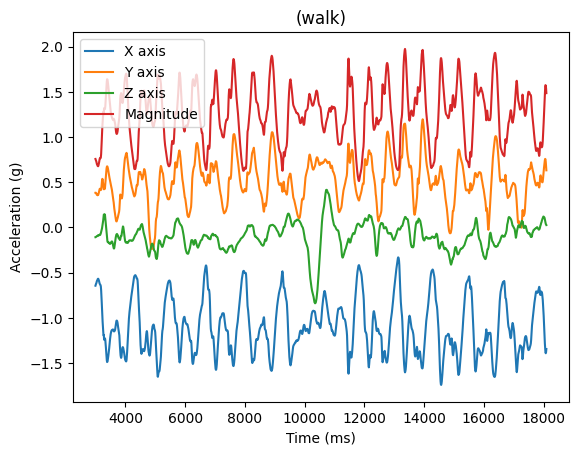

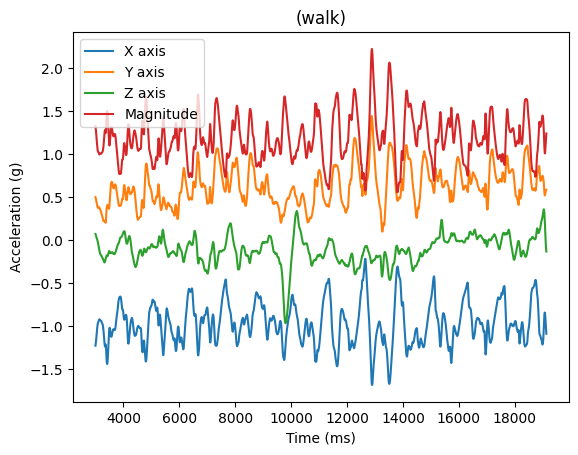

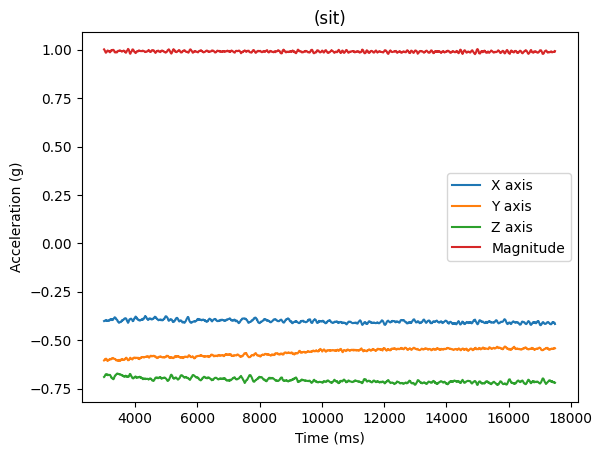

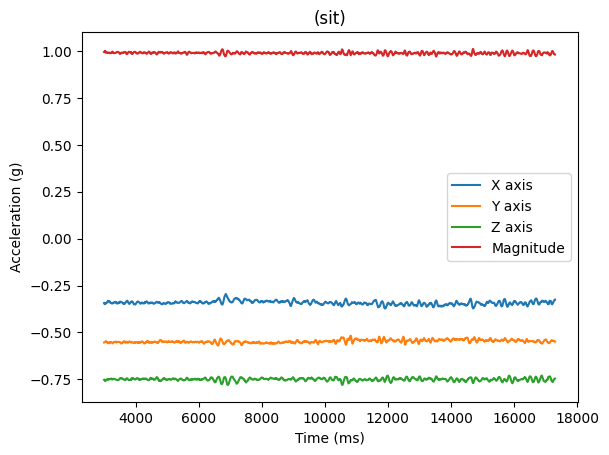

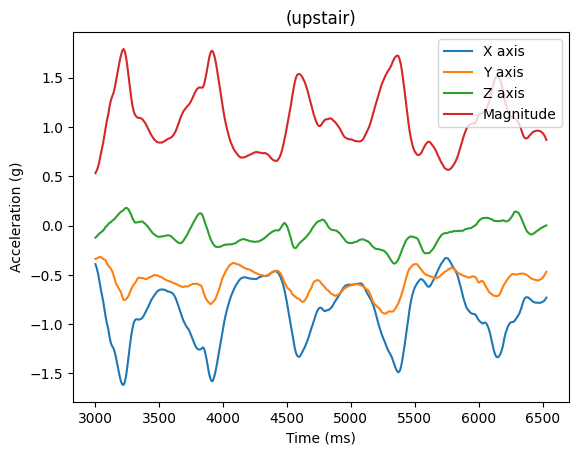

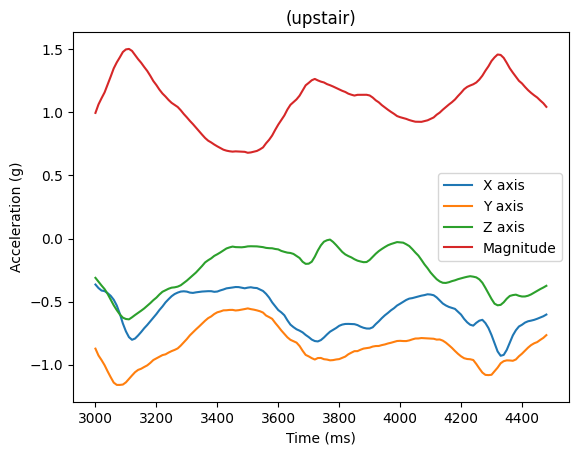

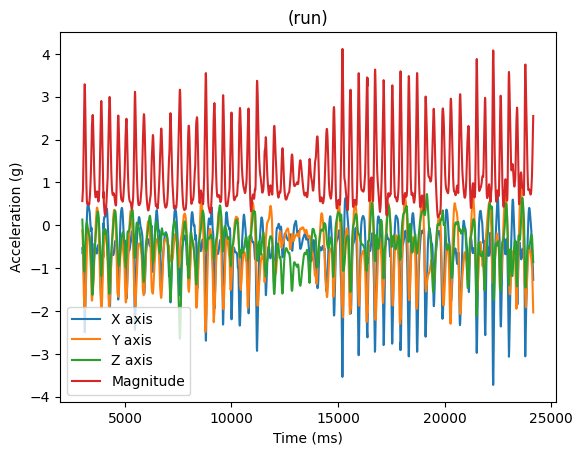

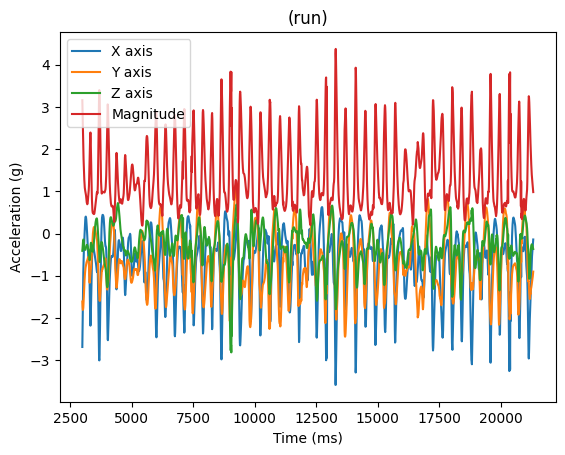

In [37]:
visualize_data(training_docs, training_data_raw)